### Sentiment analysis using Vader

In [1]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim.models import LdaModel
import warnings
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import os

nltk.download('vader_lexicon',quiet=True)

True

In [2]:
df = pd.read_csv('./data/song_lyrics_sampled_proc.csv')
sia = SentimentIntensityAnalyzer()

In [3]:
"""
apply sentiment analysis:
polarity_scores() returns a dictionary with four key sentiment metrics that
provide a comprehensive view of the sentiment:

- neg (negative): proportion of text that is perceived as negative
    range:  0-1   ->  higher values indicate a stronger presence of negative sentiment

- neu (neutral): proportion of text that is perceived as neutral
    range:  0-1   ->  higher values indicate a stronger presence of neutral sentiment

- pos (positive): proportion of text that is perceived as positive
    range:  0-1   ->  higher values indicate a stronger presence of positive sentiment

-compound: normalized, weighted composite score that summarizes the overall sentiment of the text
    range: -1, 1  ->    Values close to 1 indicate extremely positive sentiment.
                        Values close to -1 indicate extremely negative sentiment.
                        Values around 0 indicate neutral sentiment.
"""

df['sentiment'] = df['lyrics_proc'].apply(lambda x: sia.polarity_scores(x))

# separate the sentiment scores into individual columns
sentiment_df = df['sentiment'].apply(pd.Series)

df = pd.concat([df, sentiment_df], axis=1)

# Drop the 'sentiment' column
df.drop(columns=['sentiment'], inplace=True)

columns_to_display = ['title', 'artist', 'year', 'neg', 'neu', 'pos', 'compound']

print(tabulate(df[columns_to_display].head(), headers='keys', tablefmt='pretty'))

+---+------------------------------+---------------------+------+-------+-------+-------+----------+
|   |            title             |       artist        | year |  neg  |  neu  |  pos  | compound |
+---+------------------------------+---------------------+------+-------+-------+-------+----------+
| 0 |          Toothpick           |    Biting Elbows    | 2012 | 0.191 | 0.64  | 0.169 |  0.0258  |
| 1 |         6 Feet Under         |    Ana Johnsson     | 2004 | 0.145 | 0.855 |  0.0  | -0.9325  |
| 2 | The Poetaster Act 4. Scene 2 |     Ben Jonson      | 1601 | 0.107 | 0.726 | 0.167 |  0.9042  |
| 3 |           Hes Gone           | Phil Lesh & Friends | 2015 | 0.074 | 0.727 | 0.198 |  0.9393  |
| 4 |        Ill Never Say         |     Helen Ward      | 2015 | 0.421 | 0.485 | 0.093 | -0.9558  |
+---+------------------------------+---------------------+------+-------+-------+-------+----------+


/home/aresta/miniconda3/envs/nlp/lib/python3.12/site-packages/kaleido/scopes/base.py:188: DeprecationWarning:

setDaemon() is deprecated, set the daemon attribute instead



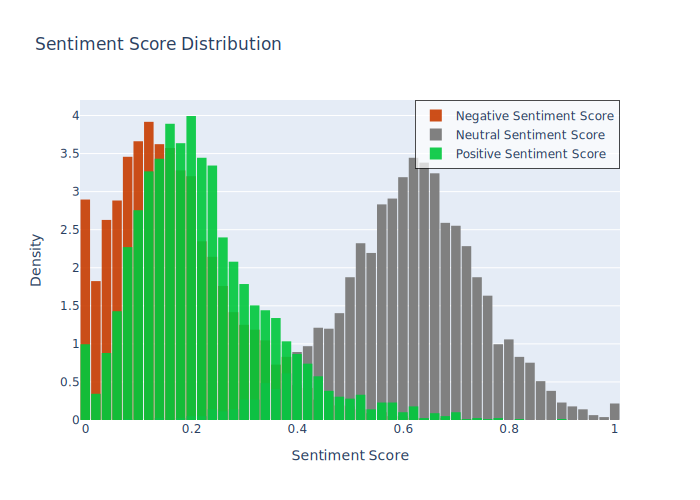

In [4]:
# Create figure
fig = go.Figure()

# Add subplot for negative scores
fig.add_trace(go.Histogram(x=df['neg'], nbinsx=50,histnorm='probability density', name='Negative Sentiment Score',marker_color='rgba(200, 60, 0, 0.9)'))

# Add subplot for neutral scores
fig.add_trace(go.Histogram(x=df['neu'], nbinsx=50,histnorm='probability density', name='Neutral Sentiment Score',opacity=1,marker_color='grey'))

# Add subplot for positive scores
fig.add_trace(go.Histogram(x=df['pos'], nbinsx=50,histnorm='probability density', name='Positive Sentiment Score',marker_color='rgba(0, 200, 60, 0.9)'))

# Update layout
fig.update_layout(
    title='Sentiment Score Distribution',
    xaxis_title='Sentiment Score',
    yaxis_title='Density',
    barmode='overlay',
    bargap=0.1,
    legend=dict(x=0.62, y=1, bgcolor='rgba(255,255,255,0.7)', bordercolor='rgba(0,0,0,0.7)', borderwidth=1),
)

# Show plot
fig.show('svg')
# Save plot
pio.write_image(fig, './plots/sentiment_score_dist.pdf')

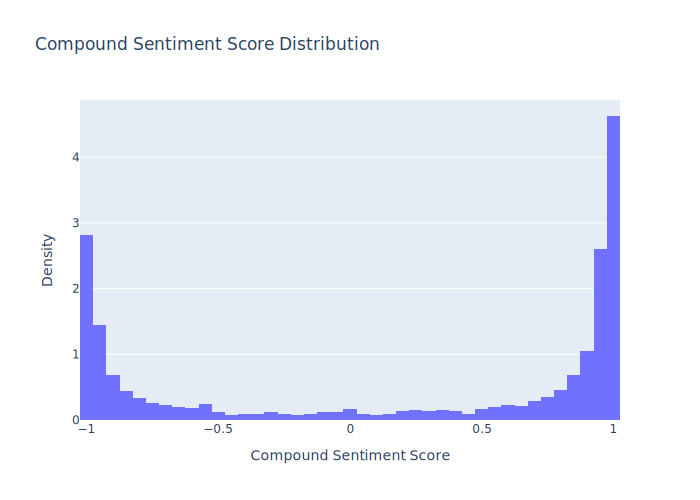

In [5]:
# Create histogram trace
histogram_trace = go.Histogram(x=df['compound'], nbinsx=100, histnorm='probability density', name='Compound Sentiment Score', marker_color='rgba(100, 100, 255, 0.9)')

# Create figure
fig = go.Figure(histogram_trace)

# Update layout
fig.update_layout(
    title='Compound Sentiment Score Distribution',
    xaxis_title='Compound Sentiment Score',
    yaxis_title='Density',
)

# Show plot
fig.show('svg')
# Save plot
pio.write_image(fig, './plots/compound_sentiment_score_dist.pdf')

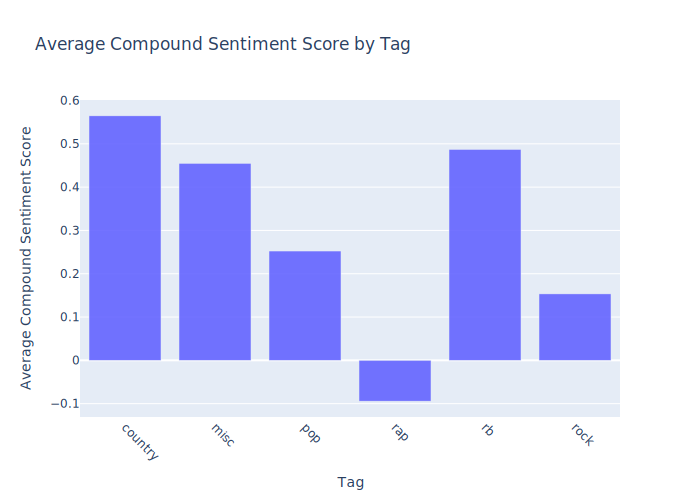

In [6]:
# Group by tag and calculate average compound sentiment score
average_compound_by_tag = df.groupby('tag')['compound'].mean()

# Create bar plot trace
barplot_trace = go.Bar(
    x=average_compound_by_tag.index,
    y=average_compound_by_tag.values,
    marker_color='rgba(100, 100, 255, 0.9)',
    name='Average Compound Sentiment Score'
)

# Create figure
fig = go.Figure(barplot_trace)

# Update layout
fig.update_layout(
    title='Average Compound Sentiment Score by Tag',
    xaxis_title='Tag',
    yaxis_title='Average Compound Sentiment Score',
    xaxis=dict(tickangle=45),
)

# Show plot
fig.show('svg')
# Save plot
pio.write_image(fig, './plots/avg_compound_sentiment_score_tag_dist.pdf')

### Topic modeling with LDA

In [21]:
# lyrics corpus
lyrics_corpus = df['lyrics_proc'].apply(lambda x: x.split())

# Create the dictionary
dictionary = corpora.Dictionary(lyrics_corpus)

# Create the corpus
corpus = [dictionary.doc2bow(text) for text in lyrics_corpus]

In [22]:

# Set parameters
num_topics = 5
passes = 15

# Train the LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    alpha='auto',
    eta='auto',
    num_topics=num_topics,
    passes=passes
)

# Save the trained model
lda_model.save('./models/lda_model.gensim')

# Load the trained LDA model
lda_model = LdaModel.load('./models/lda_model.gensim')

In [23]:
# Print the most relevant keywords for each topic
topics = lda_model.print_topics(num_topics=num_topics, num_words=3)
for topic in topics:
    print(topic)

(0, '0.010*"god" + 0.005*"life" + 0.005*"one"')
(1, '0.006*"one" + 0.005*"thing" + 0.005*"idea"')
(2, '0.018*"know" + 0.016*"love" + 0.013*"like"')
(3, '0.020*"like" + 0.017*"got" + 0.015*"get"')
(4, '0.011*"said" + 0.007*"would" + 0.007*"one"')


In [24]:
# Measure coherence within a topic
coherencemodel = CoherenceModel(model=lda_model, texts=lyrics_corpus, dictionary=dictionary, coherence='c_v')
# Suppress warnings temporarily
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #my_function_that_generates_warnings()
    print(coherencemodel.get_coherence())

0.45270986554837833


In [25]:
test_lyric = df['lyrics_proc'][0]

# Convert the preprocessed test lyric into a bag-of-words representation
test_bow = dictionary.doc2bow(test_lyric.split())

# Apply the trained LDA model to the test lyric
topic_distribution = lda_model.get_document_topics(test_bow)

# Get the topic with the highest score
highest_topic = max(topic_distribution, key=lambda x: x[1])
print(highest_topic)

# Get the main keywords for the highest topic
main_keywords = lda_model.show_topic(highest_topic[0], topn=5)

# Return the representation through the main keywords
representation = [keyword[0] for keyword in main_keywords]
representation

(2, 0.57645977)


['know', 'love', 'like', 'time', 'never']

In [26]:
# Get topic distributions
df['lda'] = [lda_model.get_document_topics(bow) for bow in corpus]
df.head()['lda']

0    [(2, 0.5764605), (3, 0.17442742), (4, 0.248524...
1                    [(0, 0.16766569), (2, 0.8306347)]
2    [(0, 0.24471664), (1, 0.4640226), (2, 0.064010...
3                   [(2, 0.78893787), (3, 0.20987621)]
4                     [(2, 0.9537869), (4, 0.0406149)]
Name: lda, dtype: object

In [28]:
#with warnings.catch_warnings():
#warnings.simplefilter("ignore")
pyLDAvis.enable_notebook()

# Convert the corpus to a gensim-specific format
gensim_corpus = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(gensim_corpus)

### TF-IDF

In [29]:

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# the corpus is the whole list of lyrics processed
corpus = df['lyrics_proc'].values

print("Corpus: ", len(corpus), "\n")

tfidf_matrix = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

# Convert TF-IDF matrix to a list of lists
tfidf_list = tfidf_matrix.toarray().tolist()

# Add TF-IDF vector list as a column named 'tf-idf'
df['tf-idf'] = tfidf_list

print("Number of features: %d" % len(feature_names), "\n")
print("Last 10 features: ", feature_names[-10:], "\n")
print ("Dimensions of the TF-IDF matrix: ", tfidf_matrix.shape, "\n")

Corpus:  3919 

Number of features: 40130 

Last 10 features:  ['родной' 'свободно' 'так' 'тебя' 'тобою' 'туда' 'улетай' 'ґtill' 'ḳôrî'
 'どういたしまして'] 

Dimensions of the TF-IDF matrix:  (3919, 40130) 



### Combine the three features into a single fixed-size vector

In [30]:
# Convert LDA topic distributions to a fixed-size vector
def lda_to_vec(lda_dist, num_topics):
    vec = np.zeros(num_topics)
    for topic, prob in lda_dist:
        vec[topic] = prob
    return vec

# Combine features
features = []
for i in range(len(df)):
    sentiment_scores = df[['neg', 'neu', 'pos', 'compound']].iloc[i].values
    lda_vector = lda_to_vec(df['lda'].iloc[i], num_topics)
    tfidf_vector = tfidf_matrix[i].toarray()[0]
    
    combined_vector = np.concatenate([sentiment_scores, lda_vector, tfidf_vector])
    features.append(combined_vector.tolist())

# Convert to numpy array
df['feature_vector'] = features
df.head()

,title,tag,artist,year,lyrics,id,lyrics_proc,neg,neu,pos,compound,lda,tf-idf,feature_vector
0,Toothpick,pop,Biting Elbows,2012,Some folks got the patience of the angels\nNot...,1166787,folk got patience angel heart well yearns veng...,0.191,0.640,0.169,0.0258,"[(2, 0.5764605), (3, 0.17442742), (4, 0.248524...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.191, 0.64, 0.169, 0.0258, 0.0, 0.0, 0.57646..."
1,6 Feet Under,pop,Ana Johnsson,2004,You just left me 6 feet under ground I'm burni...,803057,left foot ground burning sight light foot buri...,0.145,0.855,0.000,-0.9325,"[(0, 0.16766569), (2, 0.8306347)]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.145, 0.855, 0.0, -0.9325, 0.167665690183639..."
2,The Poetaster Act 4. Scene 2,misc,Ben Jonson,1601,"A Room in Lupus's House.\n\nEnter Lupus, HISTR...",674438,room house enter lupus histrio lictors tuc sta...,0.107,0.726,0.167,0.9042,"[(0, 0.24471664), (1, 0.4640226), (2, 0.064010...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.107, 0.726, 0.167, 0.9042, 0.24471664428710..."
3,Hes Gone,pop,Phil Lesh & Friends,2015,"Rat in a drain ditch, caught on a limb, you kn...",961823,rat drain ditch caught limb know better know l...,0.074,0.727,0.198,0.9393,"[(2, 0.78893787), (3, 0.20987621)]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.074, 0.727, 0.198, 0.9393, 0.0, 0.0, 0.7889..."
4,Ill Never Say,pop,Helen Ward,2015,"I'll never say ""never again"" again\nCause here...",1163619,never say never cause love head heel love neve...,0.421,0.485,0.093,-0.9558,"[(2, 0.9537869), (4, 0.0406149)]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.421, 0.485, 0.093, -0.9558, 0.0, 0.0, 0.953..."


### Here we directly apply cosine similarity and retrieve the most similar songs

In [31]:
def top_n_similar_embeddings(df, target_index, n=10):
    
    # Extract the target embedding and its cluster
    target_embedding = df.at[target_index, 'feature_vector']
    
    # Get all the embeddings    
    all_embeddings = np.stack(df['feature_vector'].values)

    # Calculate cosine similarities
    similarities = cosine_similarity([target_embedding], all_embeddings)[0]

    # Get the top n similar embeddings
    top_n_indices = np.argsort(similarities)[-n-1:][::-1]
    top_n_similar_ids = df.iloc[top_n_indices]['id'].values
    top_n_similarities = similarities[top_n_indices]

    return pd.DataFrame({
        'id': top_n_similar_ids, 
        'similarity': top_n_similarities
    })

# Show top 10 similar song to the first song (the first row is the song itself)
top_n_similar_embeddings(df,target_index=0,n=10)

,id,similarity
0,1166787,1.000000
1,1189435,0.562219
2,1129566,0.546935
3,194699,0.545490
4,114671,0.545239
5,621753,0.543224
6,961078,0.542304
7,1247365,0.533244
8,1220153,0.531490
9,666583,0.530525


In [32]:
# Save this dataframe with the USE embeddings
directory = "./data/simple_features"
file_path = "./data/simple_features/song_lyrics_simple_features.csv"
features_path = "./data/simple_features/simple_features.npy"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

df.to_csv(file_path, header='true', index=False)
# Save the features as a NumPy file
feature_vector = df['feature_vector'].values
np.save(features_path, feature_vector)

: 